In [ ]:
import numpy as np
import jax.numpy as jnp
from jax import grad, lax, jit, vmap
from jax.scipy.linalg import expm
from matplotlib.lines import Line2D
import time

# Parametric Matrix Model

In [ ]:
############
#Set up PMM params,matrices, form, and calculation
############

def get_param(n, l):
    r"""
    Initialize model parameters for the **Parametrix Matrix Model (PMM)**.

    Parameters
    ----------
    n : int
        Dimension of each matrix (i.e. Hilbert space size).
    l : int
        Number of layers (excluding the base Hamiltonian term).

    Returns
    -------
    param : np.ndarray
        A 1D array of length
        num_params = n^2 + l .... n^2 = (l+1)n^2
        containing randomly initialized parameters, which will later be reshaped
        into (l+1, n, n) Hermitian matrices.

    Notes
    -----
    These matrices correspond to effective Hamiltonian terms in the PMM model,
    which will be exponentiated into unitary operators.
    """
    num_params = n * n + l * n * n
    np.random.seed(0)
    param = np.random.randn(num_params) #+  1j * np.random.randn(num_params)
    return param

def one_unitary(mat, X):
    r"""
    Construct a single unitary operator of the form

    U = e^{-i * M * X}

    where M is a Hermitian matrix and X is a scalar (time or step size).

    Parameters
    ----------
    mat : (n, n) array
        Hermitian matrix (Hamiltonian term).
    X : float
        Scalar parameter, often interpreted as evolution time or Trotter step.

    Returns
    -------
    U : (n, n) array
        The resulting unitary matrix.
    """
    U = expm(-1j * mat * X)
    return U

def product_of_unitaries(mats, X):
    r"""
    Construct the Trotterized unitary evolution by multiplying exponentials
    of individual Hamiltonian terms.

    Parameters
    ----------
    mats : (l+1, n, n) array
        Sequence of (l+1) Hermitian matrices.
    X : float
        Scalar parameter (time or step size).

    Returns
    -------
    U_total : (n, n) array
        Product of exponentials,
        U(X) = \prod_{j=0}^l exp(-i * M_j * X ).

    Notes
    -----
    This corresponds to the **first-order Trotter approximation**:
    e^{-i * (\sum_j M_j) * X} \approx \prod_j e^{-i * M_j * X}.
    """
    Us = vmap(one_unitary, in_axes=(0, None))(mats, X)
    return jnp.linalg.multi_dot(Us)

def get_loc(n,k,array,loc):
  r"""
  Select eigenvalues from the spectrum according to a location rule.

  Parameters
  ----------
  n : int
      Dimension of the spectrum.
  k : int
      Number of eigenvalues to select.
  array : (n,) array
      Sorted list of eigenvalues.
  loc : {"low", "mid", "high"}
      Region of spectrum to extract:
      - `"low"`  : the lowest-k eigenvalues
      - `"high"` : the highest-k eigenvalues
      - `"mid"`  : the middle eigenvalue (ignores k, returns one value)

  Returns
  -------
  eigenvalue(s) : array
      Selected eigenvalues.
  """
  if loc == 'low':
      eigenvalue = array[:k]
  elif loc == "high":
      eigenvalue = array[-k:]
  elif loc =='mid':
      mid_index = n // 2 if n % 2 == 1 else (n - 1) // 2
      eigenvalue = array[mid_index]
  return eigenvalue

def get_phase(n,l,k,loc,Ms,X):
  r"""
  Perform eigen-decomposition of the Trotterized unitary and extract
  effective energy levels.

  Parameters
  ----------
  n : int
      Hilbert space dimension.
  l : int
      Number of additional matrices (depth).
  k : int
      Number of eigenvalues to extract.
  loc : str
      Location rule for eigenvalue selection ("low", "mid", "high").
  Ms : (l+1, n, n) array
      Hermitian matrices (Hamiltonian terms).
  X : float
      Scalar step size or time.

  Returns
  -------
  y_pred : array
      Selected eigenvalues, interpreted as approximate energy levels.

  Notes
  -----
  Given the total unitary
  U(X) = \prod_{j=0}^l e^{-i * M_j * X},
  its eigenvalues lie on the unit circle:
  lambda = e^{-i * E * X}, \quad E \in \mathbb{R}.
  We recover energies E from phases:
  E = -1/X arg(lambda).
  """
  U = product_of_unitaries(Ms, X)
  E_k = jnp.array(jnp.sort(-jnp.angle(jnp.linalg.eigvals(U))/X)) #obtain eigenvalues
  #E_k  =  jnp.array(jnp.sort((jnp.log(jnp.linalg.eigvals(U))/(-1j*X)).real)) #equal formalism
  y_pred = get_loc(n,k,E_k,loc)
  return y_pred

def update(n,l,k,loc,param,X):
  r"""
  Evaluate the PMM model across multiple input values of `X`.

  Parameters
  ----------
  n : int
      Dimension of Hilbert space.
  l : int
      Number of layers.
  k : int
      Number of eigenvalues to select.
  loc : str
      Eigenvalue selection rule.
  param : array
      Flat array of parameters, will be reshaped into (l+1,n,n).
  X : (m,) array
      Array of input step sizes / times.

  Returns
  -------
  y_pred : (m, k) array
      Predicted eigenvalues (energy levels) for each value of `X`.

  Notes
  -----
  - Parameters are reshaped into Hermitian matrices by symmetrization:
    M_j = (M_j + M_j^\dagger)/2.
  - For each X, the unitary is constructed, eigen-decomposed,
    and selected eigenvalues are returned.
  """
  Ms = param.reshape(l+1,n,n)
  Ms = (Ms.conj().transpose(0,2,1) + Ms)/2
  y_pred = vmap(get_phase, in_axes=(None,None,None,None,None,0))(n,l,k,loc,Ms,X)
  return y_pred

def predict(n,l,k,loc,param,X_test):
  """
  Makes a prediction given trained PMM
  """
  E = update(n,l,k,loc,param,X_test)
  return E

# Gradient Descent

In [ ]:
##################
#Machine learning part
#set up Loss function
#grad of loss function
#Gradient Descent with ADAM to learn params
###################
def Loss(param,X,y_true,n,l,k,loc):
  """
  Calculates loss function
  X: input - Tidy data format
  X = [  |    |  .....  |  ]
      [ X_0  X_2 ..... X_j ]
      [  |    |  .....  |  ]
  Y: output - Tidy data format
  y = [  |    |  .....  |  ]
      [ y_0  y_2 ..... y_l ]
      [  |    |  .....  |  ]
  param: PMM model parameters
  """
  y_pred = update(n,l,k,loc,param,X)
  cf = jnp.mean((y_true-y_pred)**2) #MSE
  return cf

def dLossdx(param,X,y_true,n,l,k,loc):
  """
  Gradient of loss
  """
  return grad(Loss, argnums=0)(param,X,y_true,n,l,k,loc)


def train(
  n, #Size of PMM
  X_train, #Training input
  y_train, #Training output
  l, #number of matrices in the PMM Hamiltonian
  k, #number of outputs (eigenvalues/observables)
  params=None, #in case one wants to load pmm parameters
  X_val=None, #Validation set input
  y_val=None, #Validation set output
  loc: str = 'low', #only used for the location of eigenvalues
  epochs = np.inf, #number of epochs/iterations for the Gradient Descent
  lr=0.01, #Learning Rate
  print_every=100, #print loss function
  batch_size=None, #size for batch gradient descent
  new_batch_every=100, #when to switch between batches
  ):

  X = X_train
  y = y_train

  param = jnp.array(get_param(n, l) if params is None else params, dtype=jnp.complex64) #obtain/load params

  #just in time for faster code
  jgrad = jit(lambda param, X, y: dLossdx(param,X,y,n,l,k,loc))

  #just in time for faster code
  jLoss = jit(lambda param, X: Loss(param,X,y,n,l,k,loc))

  print("Starting training...")
  #ADAM parameters
  b1=0.9
  b2=0.999
  eps=1e-8
  m = np.zeros(param.shape, dtype=param.dtype)
  v = np.zeros(param.shape, dtype=param.dtype)
  best_loss = np.inf
  best_param = param
  i = 0
  while i < epochs:
    g = jgrad(param, X, y)

    # flip sign on imaginary part of gradient
    g = g.conj()
    #ADAM
    # update biased first moment estimate
    m = b1 * m + (1 - b1) * g
    # update biased second raw moment estimate
    v = b2 * v + (1 - b2) * (g*g.conj())
    # compute bias-corrected first moment estimate
    mhat = m / (1 - b1 ** (i + 1))
    # compute bias-corrected second raw moment estimate
    vhat = v / (1 - b2 ** (i + 1))

    # update parameters
    param = param - lr * mhat / (np.sqrt(vhat) + eps)

    #update best loss and param
    if jLoss(param,X) < best_loss:
      best_loss = jLoss(param,X)
      best_param = param

    if i % print_every == 0:
        print(f"epoch {i} Loss = {jLoss(param,X)}")

    i += 1
  return best_param

# Trotter Example

In [ ]:
#testing to see if code works for the Trotter eigenvalue problem from paper
#can be ignored
N = 8
Ham ='heisendNN_hard2'
dt1 = 0.15
dt2 = 0.18
lendt = 10
training_dts = jnp.load(f'{N}_H{Ham}_K{20}_{dt1}_{dt2}_training_dts_{lendt}.npy')
plot_dts = jnp.load(f'{N}_H{Ham}_K{20}_{dt1}_{dt2}_plot_dts_{lendt}.npy')
training_Es = jnp.load(f'{N}_H{Ham}_K{20}_{dt1}_{dt2}_training_Es_bot_{lendt}.npy')
Es_ex = jnp.load(f'{N}_H{Ham}_K{20}_{dt1}_{dt2}_Es_ex_bot_{lendt}.npy')

In [ ]:
n = 10
l = 4
k = 3
y_train  = training_Es
X_train = training_dts.reshape(len(training_dts),1)
X_val = None
y_val = None
params = None
lr = [0.1,0.01,0.001,0.0001,0.00001,0.000001]
t1 = time.time()
print('---------------------------------------')
for i in range(len(lr)):
  print(f'learning rate {lr[i]}')
  results = train(
                    n,
                    X_train,
                    y_train,
                    l,
                    k,
                    params,
                    X_val,
                    y_val,
                    loc = 'low',
                    epochs = 10000,
                    lr=lr[i],
                    print_every=1000,
                    batch_size=len(X_train),
                    new_batch_every=100,
                    )
  params = results
  print('---------------------------------------')
t2 = time.time()
print(f'time taken: {(t2-t1)/60} min')

---------------------------------------
learning rate 0.1
Starting training...
epoch 0 Loss = 19.20290756225586
epoch 1000 Loss = 0.0025799807626754045
epoch 2000 Loss = 0.0006730412133038044
epoch 3000 Loss = 1.601543857532306e-07
epoch 4000 Loss = 0.0012372398050501943
epoch 5000 Loss = 3.888921128236689e-05
epoch 6000 Loss = 7.591661415062845e-05
epoch 7000 Loss = 2.433413505554199
epoch 8000 Loss = 4.889832496643066
epoch 9000 Loss = 1.9520108699798584
---------------------------------------
learning rate 0.01
Starting training...
epoch 0 Loss = 0.02941839024424553
epoch 1000 Loss = 1.7003792152081587e-07
epoch 2000 Loss = 1.3438513633445837e-05
epoch 3000 Loss = 2.316687499615e-07
epoch 4000 Loss = 0.00016233205678872764
epoch 5000 Loss = 1.5048656223370926e-06
epoch 6000 Loss = 3.002426751663734e-07
epoch 7000 Loss = 0.00013073258742224425
epoch 8000 Loss = 2.6952571374749823e-07
epoch 9000 Loss = 2.2751382857677527e-06
---------------------------------------
learning rate 0.001


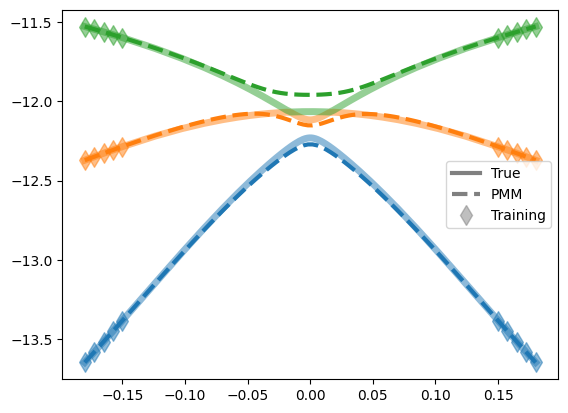

In [ ]:
import matplotlib.pyplot as plt
t = np.linspace(-0.18,0.18,100).reshape(100,1)
pmm_pred =predict(n=n,l=4,k=3,loc='low', param=params, X_test=t)
for k in range(3):
  plt.plot(plot_dts,Es_ex[:,k],lw=5,alpha=0.5,color=f'C{k}')
  plt.plot(t,pmm_pred[:,k],lw=3,ls='--',color=f'C{k}')
  plt.scatter(training_dts,training_Es[:,k],marker='d',s=100,alpha=0.5)

# Create custom legend handles
custom_lines = [
    Line2D([0], [0], color='gray', lw=3, linestyle='-', label='True'),
    Line2D([0], [0], color='gray', lw=3, linestyle='--', label='PMM'),
    Line2D([0], [0], color='gray', marker='d', markersize=10, linestyle='None', label='Training', alpha=0.5)
]

plt.legend(handles=custom_lines)
plt.show()